<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"venkat2ram","key":"c233093fe613d832ab86883054070879"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-23 00:53:41          83462  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          14326  
promptcloud/jobs-on-naukricom                               Jobs On Naukri.com                                    3MB  2020-06-15 10:51:07            412  
shubh0799/churn-modelling                                   Churn Modelling                                     262KB  2020-06-20 17:33:28            272  
mikahama/the-best-sarcasm-annotated-dataset-in-spanish      The 

In [7]:
cd /content/

/content


In [8]:
! kaggle competitions download -c dogs-vs-cats

100% 543M/543M [00:02<00:00, 221MB/s]
100% 543M/543M [00:02<00:00, 209MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 85.1MB/s]
 96% 259M/271M [00:01<00:00, 222MB/s]
100% 271M/271M [00:01<00:00, 200MB/s]


In [9]:
! unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

In [10]:
mv /content/train /content/dogs-vs-cats

In [11]:
cd 


/root


In [12]:
cd /content/dogs-vs-cats/

/content/dogs-vs-cats


In [13]:
!mkdir train
!mkdir test
!mkdir valid
!mkdir train/dog
!mkdir test/dog
!mkdir valid/dog
!mkdir train/cat
!mkdir test/cat
!mkdir valid/cat

In [14]:
cd train

/content/dogs-vs-cats/train


In [15]:
import glob
import os
import random
import shutil

In [16]:
os.chdir('/content/dogs-vs-cats')
for i in random.sample(glob.glob('cat*'), 500):
  shutil.move(i, 'train/cat')      
for i in random.sample(glob.glob('dog*'), 500):
  shutil.move(i, 'train/dog')
for i in random.sample(glob.glob('cat*'), 100):
  shutil.move(i, 'valid/cat')        
for i in random.sample(glob.glob('dog*'), 100):
  shutil.move(i, 'valid/dog')
for i in random.sample(glob.glob('cat*'), 50):
  shutil.move(i, 'test/cat')      
for i in random.sample(glob.glob('dog*'), 50):
  shutil.move(i, 'test/dog')
os.chdir('../../')

In [17]:
!tree


/bin/bash: tree: command not found


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation,Dense,Flatten, BatchNormalization, Conv2D,MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline


In [19]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
train_path='/content/dogs-vs-cats/train'
test_path='/content/dogs-vs-cats/test'
valid_path='/content/dogs-vs-cats/valid'

Create directory iterator.

In [23]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path,target_size=(224,224),classes=['cat','dog'],batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224,224),classes=['cat','dog'],batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),classes=['cat','dog'],batch_size=10,shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [24]:
img,labels=next(train_batches)

In [25]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

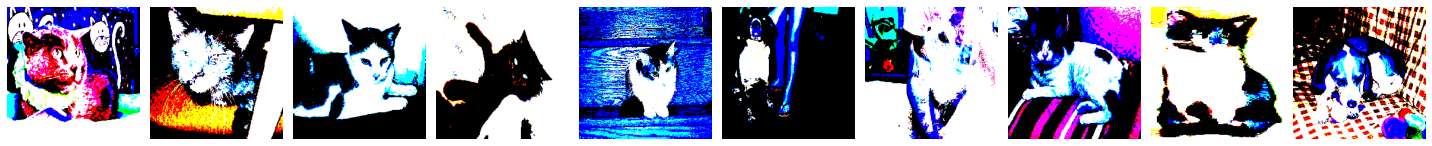

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [26]:
plotImages(img)
print(labels)

Define model.

In [27]:
model=Sequential([
                  Conv2D(filters=32,kernel_size=(3,3),activation='relu', input_shape=(224,224,3),padding='same'),
                  MaxPool2D(pool_size=(2,2), strides=2),
                  #Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
                  #MaxPool2D(pool_size=(2,2), strides=2),
                  Flatten(),
                  Dense(units=2,activation='softmax')
])

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 802818    
Total params: 803,714
Trainable params: 803,714
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
model.fit(train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
100/100 - 32s - loss: 91.8397 - accuracy: 0.5720 - val_loss: 99.8499 - val_accuracy: 0.5200
Epoch 2/10
100/100 - 36s - loss: 39.8620 - accuracy: 0.6520 - val_loss: 84.9391 - val_accuracy: 0.5300
Epoch 3/10
100/100 - 32s - loss: 21.3443 - accuracy: 0.7330 - val_loss: 24.4325 - val_accuracy: 0.6100
Epoch 4/10
100/100 - 32s - loss: 10.0614 - accuracy: 0.8180 - val_loss: 31.9887 - val_accuracy: 0.6250
Epoch 5/10
100/100 - 32s - loss: 2.3634 - accuracy: 0.9200 - val_loss: 25.0608 - val_accuracy: 0.6150
Epoch 6/10
100/100 - 32s - loss: 4.0111 - accuracy: 0.8950 - val_loss: 22.4531 - val_accuracy: 0.6350
Epoch 7/10
100/100 - 32s - loss: 2.2263 - accuracy: 0.9230 - val_loss: 20.7941 - val_accuracy: 0.6300
Epoch 8/10
100/100 - 32s - loss: 1.6685 - accuracy: 0.9410 - val_loss: 17.4221 - val_accuracy: 0.6200
Epoch 9/10
100/100 - 32s - loss: 2.6233 - accuracy: 0.9190 - val_loss: 22.5559 - val_accuracy: 0.6400
Epoch 10/10
100/100 - 32s - loss: 3.0299 - accuracy: 0.9200 - val_loss: 22.125

Predict test data

In [55]:
predictions=model.predict(x=test_batches,verbose=0)

In [56]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [61]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions, axis=-1))

In [62]:
cm

array([[31, 19],
       [14, 36]])

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[31 19]
 [14 36]]


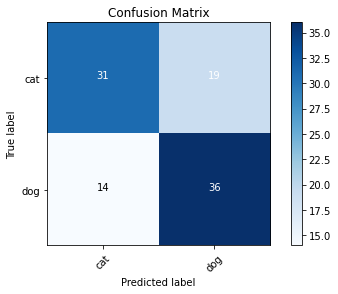

In [64]:
plot_confusion_matrix(cm,classes=['cat','dog'],title='Confusion Matrix')

Copy the pre trained VGG16 model from Keras.

In [28]:
vgg_model=tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 8s 0us/step


In [49]:
model=Sequential()

In [50]:
for layer in vgg_model.layers[:-1]:
  model.add(layer)

In [51]:
for layer in model.layers:
  layer.trainable=False

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [53]:
model.add(Dense(units=2,activation='softmax'))

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Train the model:

In [55]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics='accuracy')

In [56]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
100/100 - 9s - loss: 0.3285 - accuracy: 0.8610 - val_loss: 0.0832 - val_accuracy: 0.9800
Epoch 2/10
100/100 - 9s - loss: 0.0860 - accuracy: 0.9720 - val_loss: 0.0595 - val_accuracy: 0.9850
Epoch 3/10
100/100 - 9s - loss: 0.0575 - accuracy: 0.9880 - val_loss: 0.0487 - val_accuracy: 0.9850
Epoch 4/10
100/100 - 9s - loss: 0.0436 - accuracy: 0.9910 - val_loss: 0.0390 - val_accuracy: 0.9900
Epoch 5/10
100/100 - 9s - loss: 0.0353 - accuracy: 0.9930 - val_loss: 0.0362 - val_accuracy: 0.9900
Epoch 6/10
100/100 - 9s - loss: 0.0277 - accuracy: 0.9940 - val_loss: 0.0368 - val_accuracy: 0.9900
Epoch 7/10
100/100 - 9s - loss: 0.0214 - accuracy: 0.9940 - val_loss: 0.0384 - val_accuracy: 0.9900
Epoch 8/10
100/100 - 9s - loss: 0.0179 - accuracy: 0.9970 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 9/10
100/100 - 9s - loss: 0.0149 - accuracy: 0.9970 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 10/10
100/100 - 9s - loss: 0.0126 - accuracy: 0.9970 - val_loss: 0.0307 - val_accuracy: 0.9900

**Rough**

In [60]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)